# CMIP6 Plant Hardiness Zone Maps for Alaska

### Downscale CMIP6 projections using WRF'd ERA5 data for (most of) Alaska and make USDA hardiness zone maps!

This is Kyle's project for the 2024 holiday hackathing.

In [11]:
import time
from pathlib import Path
import cftime
import dask
import rioxarray
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import LocalCluster, Client
from pyproj import CRS, Transformer, Proj
from xclim import indices, sdba
from xclim.core.units import convert_units_to
from xclim.sdba.detrending import LoessDetrend
from xarray.coding.calendar_ops import convert_calendar

# path to reference ERA5 data
# this is ERA5 data that has been regridded to EPSG:3338 via bilinear interpolation using defaults with rioxarray
# era5_fp = Path("/beegfs/CMIP6/kmredilla/downscaling/era5_fine.nc")

cmip6_dir = Path("/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid")

# path to save adjusted data
adj_dir = Path("/beegfs/CMIP6/kmredilla/cmip6_4km_3338/adjusted")
adj_dir.mkdir(exist_ok=True)

tmp_fn = "tasmin_Amon_{model}_{scenario}_adj_{start}-{end}.nc"

In [22]:
# Functions for regridding 4km ERA5-WRF data to 3338


# add lat lon coords to ref ERA5 data
def add_lat_lon_coords(era5_ds):
    """ERA5 does not have lat lon coords. This function adds lat lon coords to the ERA5 data for regridding CMIP6-->target with xESMF.
    No longer used in this notebook.
    """
    import numpy as np
    from pyproj import Transformer

    transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)
    xx, yy = np.meshgrid(era5_ds["x"].values, era5_ds["y"].values)
    lat, lon = transformer_3338_to_4326.transform(xx, yy)
    era5_ds = era5_ds.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

    return era5_ds


def reproject_wrf_3338(geo_ds, da):
    """reproject a WRF dataarray to EPSG:3338. Used for getting the landmask from the WRF geogrid on the target grid."""
    wrf_proj = "+proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null"

    # WGS84 projection
    wgs_proj = Proj(proj="latlong", datum="WGS84")
    wgs_to_wrf_transformer = Transformer.from_proj(wgs_proj, wrf_proj)

    # this is where we plug in the center longitude of the domain to get the center x, y in projected space
    e, n = wgs_to_wrf_transformer.transform(
        geo_ds.attrs["CEN_LON"], geo_ds.attrs["TRUELAT1"]
    )

    # now compute the rest of the grid based on x/y dimension lengths and grid spacing
    dx = dy = 4000
    nx = da.west_east.shape[0]
    ny = da.south_north.shape[0]
    x0 = -(nx - 1) / 2.0 * dx + e
    y0 = -(ny - 1) / 2.0 * dy + n
    # 2d grid coordinate values
    x = np.arange(nx) * dx + x0
    y = np.arange(ny) * dy + y0

    wrf_crs = CRS.from_proj4(wrf_proj)
    da = (
        da.rename({"south_north": "y", "west_east": "x"})
        .assign_coords({"y": ("y", y), "x": ("x", x)})
        .rio.set_spatial_dims("x", "y")
        .to_dataset()
        .rio.write_crs(wrf_crs)
    )

    da_3338 = da.rio.reproject("EPSG:3338")

    return da_3338


# Functions for bias adjustment


# all MONTHLY files have date strings of format "YYYYMM-YYYYMM". Use this info to choose the files that cover a given time period
def get_files_for_period(files, start_date, end_date):
    def parse_date(f, which):
        which_lu = {"start": 0, "end": 1}
        return int(f.name.split(".")[0].split("_")[-1].split("-")[which_lu[which]])

    fps = [
        f
        for f in files
        if not (
            (parse_date(f, "end") < start_date) or (parse_date(f, "start") > end_date)
        )
    ]
    return sorted(fps)


def get_sim_fps(cmip6_dir, model, scenario, freq, var_id, start_date, end_date):
    all_fps = list(cmip6_dir.glob(f"{model}/{scenario}/{freq}/{var_id}/*.nc"))
    return get_files_for_period(all_fps, start_date, end_date)


# Note, we load all dask arrays into memory before processing.
# This ended up being more robust for this particular case.
def train_hist_adj(
    ref,
    cmip6_dir,
    model,
):
    hist_fps = get_sim_fps(
        cmip6_dir, model, "historical", "Amon", "tasmin", HIST_START, HIST_END
    )
    if len(hist_fps) == 0:
        print(f"No historical files found for {model}")
        return None, None
    hist_ds = xr.open_mfdataset(hist_fps)

    print(f"loading historical data for {model}")
    start_time = time.perf_counter()
    hist = hist_ds["tasmin"].load()
    print(
        f"loaded historical data for {model}, elapsed time: {time.perf_counter() - start_time}"
    )

    kind = "+"
    train_kwargs = dict(
        ref=ref,
        hist=hist,
        nquantiles=25,
        group="time.month",
        kind=kind,
    )

    dqm = sdba.QuantileDeltaMapping.train(**train_kwargs)

    hist_adj = (
        (
            dqm.adjust(
                hist,
                extrapolation="constant",
                interp="nearest",
            )
        )
        .rename("tasmin")
        .assign_coords({"model": model, "scenario": "historical"})
        .expand_dims(["model", "scenario"])
    )

    return dqm, hist_adj


def adjust_sim(dqm, cmip6_dir, model, scenario):

    sim_fps = get_sim_fps(
        cmip6_dir,
        model,
        scenario,
        "Amon",
        "tasmin",
        SIM_START,
        SIM_END,
    )

    if len(sim_fps) == 0:
        print(f"No scenario files found for {model} {scenario}")
        return None
    sim_ds = xr.open_mfdataset(sim_fps)

    print(f"loading projected data for {model}, {scenario}")
    start_time = time.perf_counter()
    sim = sim_ds["tasmin"].load()
    print(
        f"loaded projected data for {model}, {scenario} elapsed time: {time.perf_counter() - start_time}"
    )

    sim_adj = (
        dqm.adjust(
            sim,
            extrapolation="constant",
            interp="nearest",
        )
        .rename("tasmin")
        .assign_coords({"model": model, "scenario": scenario})
        .expand_dims(["model", "scenario"])
    )

    return sim_adj

### Reference data

We will work with the ERA5 data that has been downscaled with WRF to 4km (C. Waigl). This will be our historical reference data.

We have a version of this data that has been regridded to EPSG:3338 from the native polar steregraphic projection used in the WRF simulations. The regridding for this dataset was done using a function like that found in the code block above, relying on `rioxarray` to choose a sane default target grid.

Because hardiness zones are based on annual extreme minimum temperatures, we will use the `t2min` ERA5 variable, minimum 2m air temperature.

Open a connection to this dataset:

In [3]:
tmp_era5_fn = "era5_{var_id}_{year}_3338.nc"

era5_dir = Path("/beegfs/CMIP6/kmredilla/downscaling/era5_3338")

era5_fps = []
for year in range(1985, 2015):
    era5_fps.extend(list(era5_dir.glob(tmp_era5_fn.format(var_id="t2min", year=year))))

era5_ds = xr.open_mfdataset(era5_fps)
# add units for xclim ops
era5_ds["t2min"].attrs["units"] = "K"

Here is a snapshot of that data. It does not have a full AK extent. Included are AK's climate divisions from our API (because I couldn't find a full state boundary through it!)

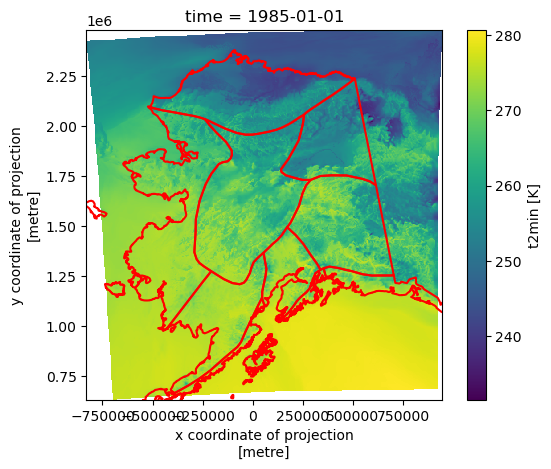

In [4]:
tmp_url = "https://earthmaps.io/boundary/area/CD{id}"
urls = [tmp_url.format(id=id) for id in range(1, 14)]
boro_gdf = pd.concat([gpd.read_file(url) for url in urls], ignore_index=True)

era5_ds["t2min"].isel(time=0).plot()
boro_gdf.to_crs(3338).boundary.plot(ax=plt.gca(), edgecolor="red")
plt.show()

Since the focus of this notebook is on growing things on land, it will be helpful to have a landmask. Here we will pull and regrid the landmask from the WRF "geogrid" file (special file):

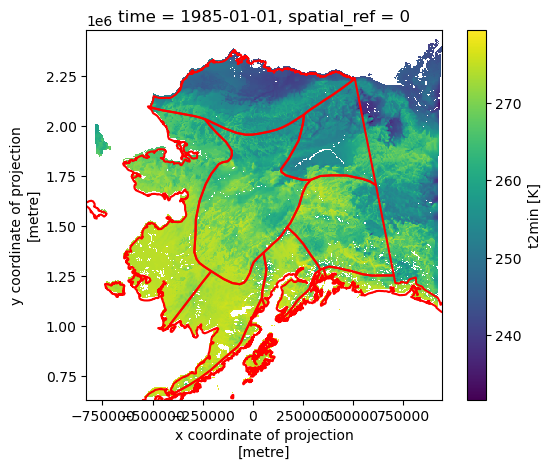

In [5]:
geo_ds = xr.open_dataset("/beegfs/CMIP6/wrf_era5/geo_em.d02.nc")
landmask = reproject_wrf_3338(geo_ds, geo_ds["LANDMASK"].sel(Time=0))
landmask = landmask["LANDMASK"].rename("landmask")
# make all non-land points nan
landmask = landmask.where(landmask == 1, np.nan)

era5_ds["t2min"].where(~landmask.isnull()).isel(time=0).plot()
boro_gdf.to_crs(3338).boundary.plot(ax=plt.gca(), edgecolor="red")
# landmask.plot.contour(ax=plt.gca(), colors="black")
plt.show()

### Resample to monthly

To prep the daily ERA5 data for monthly bias adjustment, we to resample it to a monthly frequency and also convert the calendar to a no-leap version to match that of the regridded CMIP6 data:

In [6]:
ref = convert_calendar(
    convert_units_to(era5_ds["t2min"].resample(time="1ME").min(), "degC"), "noleap"
)

We will try loading this monthly dataset into memory to try and help bias-adjustment later on.

In [8]:
ref = ref.load()

Here is the time series for the grid cell overlapping Fairbanks (dashed red lines at 0 and -40 °C), as a quick check on the data:

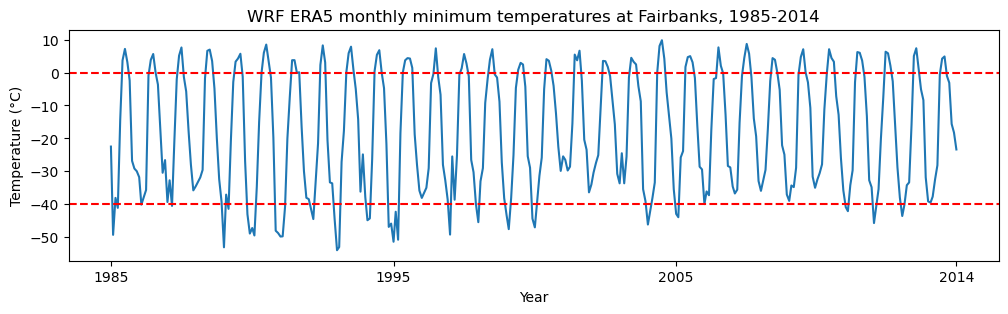

In [9]:
# fairbanks coordinates
x = 297504.5377500105
y = 1667301.4672109024
ref.sel(x=x, y=y, method="nearest").plot(figsize=(12, 3))
plt.axhline(y=-40, color="r", linestyle="--")
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks(
    ticks=[
        ref.time.values[0],
        cftime.DatetimeNoLeap(1995, 1, 31, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2005, 1, 31, 0, 0, 0, 0, has_year_zero=True),
        ref.time.values[-1],
    ],
    labels=[ref.time.dt.year.values[0], 1995, 2005, ref.time.dt.year.values[-1]],
)
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("WRF ERA5 monthly minimum temperatures at Fairbanks, 1985-2014")
plt.show()

### ERA5 hardiness map

And now we can create our first cold-hardiness map from these monthly reference data!

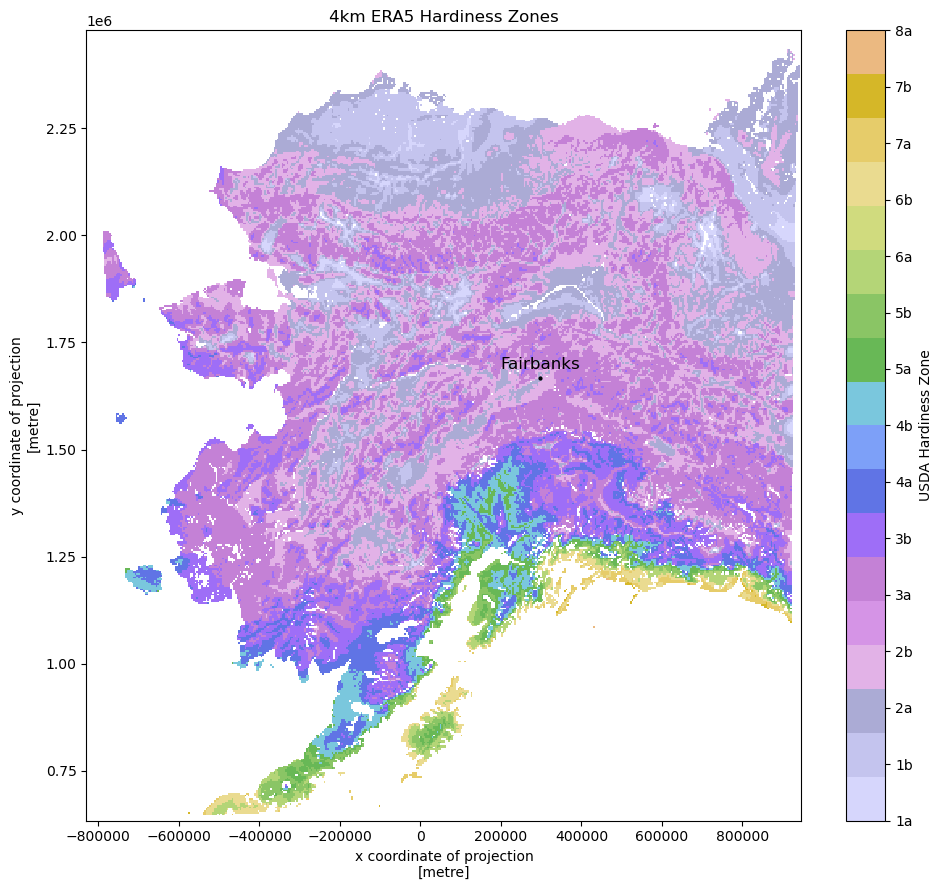

In [116]:
# Define the color ramp (gathered from USDA maps with color picker tool):

# USDA zones color ramp
zones_ramp = {
    "1a": ("214", "214", "252"),
    "1b": ("196", "196", "238"),
    "2a": ("171", "171", "213"),
    "2b": ("226", "178", "231"),
    "3a": ("213", "148", "230"),
    "3b": ("196", "129", "214"),
    "4a": ("158", "110", "247"),
    "4b": ("96", "116", "229"),
    "5a": ("125", "160", "248"),
    "5b": ("122", "199", "221"),
    "6a": ("104", "184", "86"),
    "6b": ("138", "197", "101"),
    "7a": ("180", "213", "119"),
    "7b": ("208", "219", "126"),
    "8a": ("234", "219", "144"),
    "8b": ("230", "204", "106"),
    "9a": ("213", "183", "296"),
    "9b": ("235", "185", "129"),
}

# Create a color map from the zones_ramp dictionary
colors = [tuple(int(c) / 255 for c in color) for color in zones_ramp.values()]
cmap = mcolors.ListedColormap(colors)

ref_hardiness = indices.hardiness_zones(ref, window=30).isel(time=-1)
im = ref_hardiness.where(~landmask.isnull()).plot(
    cmap=cmap, figsize=(10, 9), add_colorbar=False
)

plt.plot(x, y, "o", color="black", markersize=2)  # Add a smaller red dot
plt.text(x, y + 20000, "Fairbanks", color="black", fontsize=12, ha="center")

positions = np.linspace(0, 17, 18)
labels = list(zones_ramp.keys())
val_lookup = dict(zip(positions, labels))


def formatter_func(x, pos):
    "The two args are the value and tick position"
    val = val_lookup[x]
    return val


formatter = plt.FuncFormatter(formatter_func)
# We must be sure to specify the ticks matching our target names
cbar = plt.colorbar(im, ticks=positions, format=formatter)
# cbar = plt.colorbar(im, ticks=positions, values=labels, spacing="proportional")

cbar.set_label("USDA Hardiness Zone")
plt.title("4km ERA5 Hardiness Zones")

plt.tight_layout()

### First caveat: warm bias?

Unfortunately, this doesn't look quite as cold as the current [hardiness map for Alaska](https://planthardiness.ars.usda.gov/system/files/AK150_HS.png). We will move forward anyway :)

### CMIP6 downscaling

So our downscaling process consists of two steps:
1. regridding from the coarse CMIP6 grid to the 4km 3338 grid
2. Bias adjustment of these data via quantile delta mapping using ERA5 as the reference data


We have all of the monthly CMIP6 data we will need already regridded in a separate effort, stored in the `cmip6_dir` variable. So we will only need to work on step 2. from above. 

This consists of models in our ensemble that have monthly minimum temperature (`tasmin`) data available for the "historical" experiment and at least one future SSP. 

There are 9 models in our 12-model ensemble that have historical monthly minimum temperature data available already:
* CNRM-CM6-1-HR
* EC-Earth3-Veg
* GFDL-ESM4
* HadGEM3-GC31-LL
* HadGEM3-GC31-MM
* KACE-1-0-G
* MIROC6
* MPI-ESM1-2-HR
* MRI-ESM2-0

Note - two additional models do have daily minimum temperature data that can be resampled to monthly (eventually):
* NorESM2-MM
* TaiESM1

### Bias-adjustment

Here we will perform the bias adjustment. This section doesn't work great. I have been having issues with completing these adjustments in the loop-style implementation, and so managed to adjust and save the data after multiple tries. Also tried multiple things to silence the many warnings that print for each iteration, with no success. 

In [14]:
models = [
    "CNRM-CM6-1-HR",
    "EC-Earth3-Veg",
    "GFDL-ESM4",
    "HadGEM3-GC31-LL",
    "HadGEM3-GC31-MM",
    "KACE-1-0-G",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
]

HIST_START = int(ref.time.values[0].strftime("%Y%m"))
HIST_END = int(ref.time.values[-1].strftime("%Y%m"))

SIM_START = 201501
SIM_END = 209912

In [ ]:
dqm_lu = {}


# for model in models:
for model in models[1:]:
    dqm, hist_adj = train_hist_adj(
        ref,
        cmip6_dir,
        model,
    )
    dqm_lu[model] = dqm
    hist_adj.to_netcdf(
        adj_dir.joinpath(
            tmp_fn.format(
                model=model, scenario="historical", start=HIST_START, end=HIST_END
            )
        )
    )
    print(f"Finished {model} historical")

    for scenario in ["ssp245", "ssp370", "ssp585"]:
        adj = adjust_sim(dqm, cmip6_dir, model, scenario)
        if adj is None:
            continue
        # or just write to output?
        adj.to_netcdf(
            adj_dir.joinpath(
                tmp_fn.format(
                    model=model, scenario=scenario, start=SIM_START, end=SIM_END
                )
            )
        )
        # adj_das.append(adj)
        # sim_das.append(sim)
        print(f"Finished {model} {scenario}")

loading historical data for EC-Earth3-Veg
loaded historical data for EC-Earth3-Veg, elapsed time: 2.6422911979607306


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished EC-Earth3-Veg historical
loading projected data for EC-Earth3-Veg, ssp245
loaded projected data for EC-Earth3-Veg, ssp245 elapsed time: 6.67558131297119


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished EC-Earth3-Veg ssp245
loading projected data for EC-Earth3-Veg, ssp370
loaded projected data for EC-Earth3-Veg, ssp370 elapsed time: 6.1917661289917305


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished EC-Earth3-Veg ssp370
loading projected data for EC-Earth3-Veg, ssp585
loaded projected data for EC-Earth3-Veg, ssp585 elapsed time: 6.904585285985377


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished EC-Earth3-Veg ssp585
loading historical data for GFDL-ESM4
loaded historical data for GFDL-ESM4, elapsed time: 2.4390547439688817


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished GFDL-ESM4 historical
loading projected data for GFDL-ESM4, ssp245
loaded projected data for GFDL-ESM4, ssp245 elapsed time: 5.903852173010819


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished GFDL-ESM4 ssp245
loading projected data for GFDL-ESM4, ssp370
loaded projected data for GFDL-ESM4, ssp370 elapsed time: 5.86032353999326


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished GFDL-ESM4 ssp370
loading projected data for GFDL-ESM4, ssp585
loaded projected data for GFDL-ESM4, ssp585 elapsed time: 5.386209294956643


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished GFDL-ESM4 ssp585
loading historical data for HadGEM3-GC31-LL
loaded historical data for HadGEM3-GC31-LL, elapsed time: 1.9729893769836053


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished HadGEM3-GC31-LL historical
loading projected data for HadGEM3-GC31-LL, ssp245
loaded projected data for HadGEM3-GC31-LL, ssp245 elapsed time: 4.518997654959094


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished HadGEM3-GC31-LL ssp245
No scenario files found for HadGEM3-GC31-LL ssp370
loading projected data for HadGEM3-GC31-LL, ssp585
loaded projected data for HadGEM3-GC31-LL, ssp585 elapsed time: 5.225499737018254


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished HadGEM3-GC31-LL ssp585
loading historical data for HadGEM3-GC31-MM
loaded historical data for HadGEM3-GC31-MM, elapsed time: 2.0797368389903568


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished HadGEM3-GC31-MM historical
No scenario files found for HadGEM3-GC31-MM ssp245
No scenario files found for HadGEM3-GC31-MM ssp370
loading projected data for HadGEM3-GC31-MM, ssp585
loaded projected data for HadGEM3-GC31-MM, ssp585 elapsed time: 4.972836769011337


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished HadGEM3-GC31-MM ssp585
loading historical data for KACE-1-0-G
loaded historical data for KACE-1-0-G, elapsed time: 1.99476826103637


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished KACE-1-0-G historical
loading projected data for KACE-1-0-G, ssp245
loaded projected data for KACE-1-0-G, ssp245 elapsed time: 4.885666513990145


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished KACE-1-0-G ssp245
loading projected data for KACE-1-0-G, ssp370
loaded projected data for KACE-1-0-G, ssp370 elapsed time: 4.679839115997311


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished KACE-1-0-G ssp370
loading projected data for KACE-1-0-G, ssp585
loaded projected data for KACE-1-0-G, ssp585 elapsed time: 4.7185384900076315


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished KACE-1-0-G ssp585
loading historical data for MIROC6
loaded historical data for MIROC6, elapsed time: 1.9297754139988683


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MIROC6 historical
loading projected data for MIROC6, ssp245
loaded projected data for MIROC6, ssp245 elapsed time: 5.241480692988262


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MIROC6 ssp245
loading projected data for MIROC6, ssp370
loaded projected data for MIROC6, ssp370 elapsed time: 4.961482669052202


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MIROC6 ssp370
loading projected data for MIROC6, ssp585
loaded projected data for MIROC6, ssp585 elapsed time: 5.164410944038536


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MIROC6 ssp585
loading historical data for MPI-ESM1-2-HR
loaded historical data for MPI-ESM1-2-HR, elapsed time: 1.9928206200129353


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MPI-ESM1-2-HR historical
loading projected data for MPI-ESM1-2-HR, ssp245
loaded projected data for MPI-ESM1-2-HR, ssp245 elapsed time: 4.785422622051556


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MPI-ESM1-2-HR ssp245
loading projected data for MPI-ESM1-2-HR, ssp370
loaded projected data for MPI-ESM1-2-HR, ssp370 elapsed time: 10.151596412993968


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MPI-ESM1-2-HR ssp370
loading projected data for MPI-ESM1-2-HR, ssp585
loaded projected data for MPI-ESM1-2-HR, ssp585 elapsed time: 7.279384082008619


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MPI-ESM1-2-HR ssp585
loading historical data for MRI-ESM2-0
loaded historical data for MRI-ESM2-0, elapsed time: 1.8854366820305586


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MRI-ESM2-0 historical
loading projected data for MRI-ESM2-0, ssp245
loaded projected data for MRI-ESM2-0, ssp245 elapsed time: 5.362142489000689


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MRI-ESM2-0 ssp245
loading projected data for MRI-ESM2-0, ssp370
loaded projected data for MRI-ESM2-0, ssp370 elapsed time: 6.326056896010414


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MRI-ESM2-0 ssp370
loading projected data for MRI-ESM2-0, ssp585
loaded projected data for MRI-ESM2-0, ssp585 elapsed time: 6.348997453984339


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xclim/sdba/utils.py:384: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


Finished MRI-ESM2-0 ssp585


In [24]:
fps = list(adj_dir.glob("*.nc"))
proj_fps = [f for f in fps if "ssp" in f.name]

with dask.config.set(**{"array.slicing.split_large_chunks": False}):
    adj_proj_ds = xr.open_mfdataset(proj_fps)

In [25]:
proj_hardiness = (
    indices.hardiness_zones(adj_proj_ds["tasmin"])
    .transpose("model", "scenario", "time", "y", "x")
    .load()
)

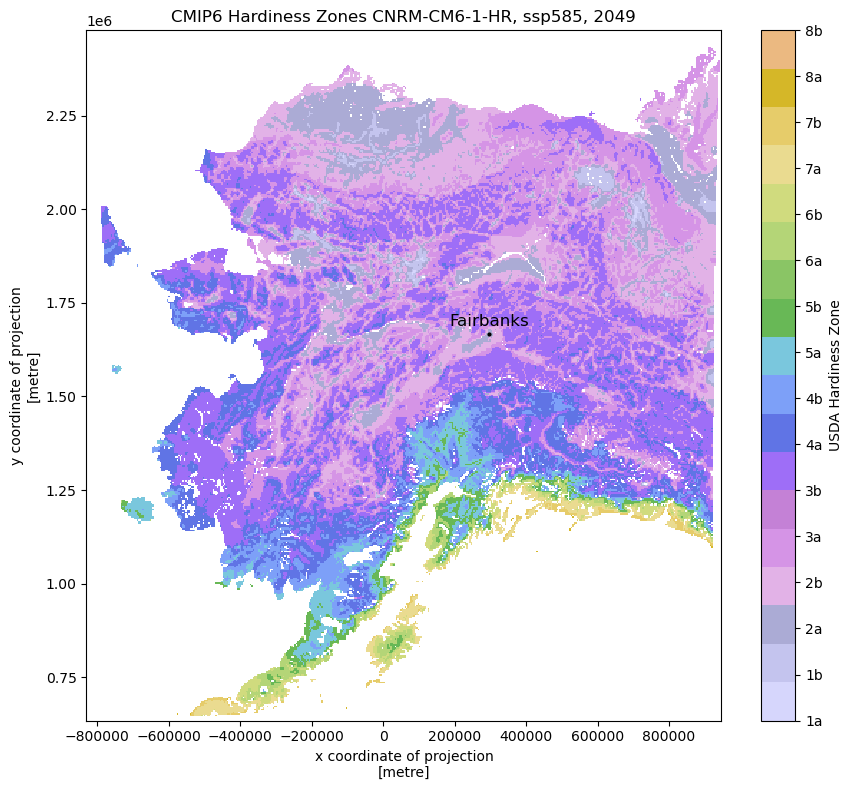

In [96]:
model = models[0]
scenario = "ssp585"
year = 2049

im = (
    proj_hardiness.sel(model=model, scenario=scenario, time=str(year))
    .drop_vars("height")
    .where(~landmask.isnull())
    .plot(cmap=cmap, figsize=(9, 8), add_colorbar=False)
)

plt.plot(x, y, "o", color="black", markersize=2)  # Add a smaller red dot
plt.text(x, y + 20000, "Fairbanks", color="black", fontsize=12, ha="center")

# We must be sure to specify the ticks matching our target names
cbar = plt.colorbar(im, ticks=positions, format=formatter, spacing="proportional")

cbar.set_label("USDA Hardiness Zone")
plt.title(f"CMIP6 Hardiness Zones {model}, {scenario}, {year}")

plt.tight_layout()

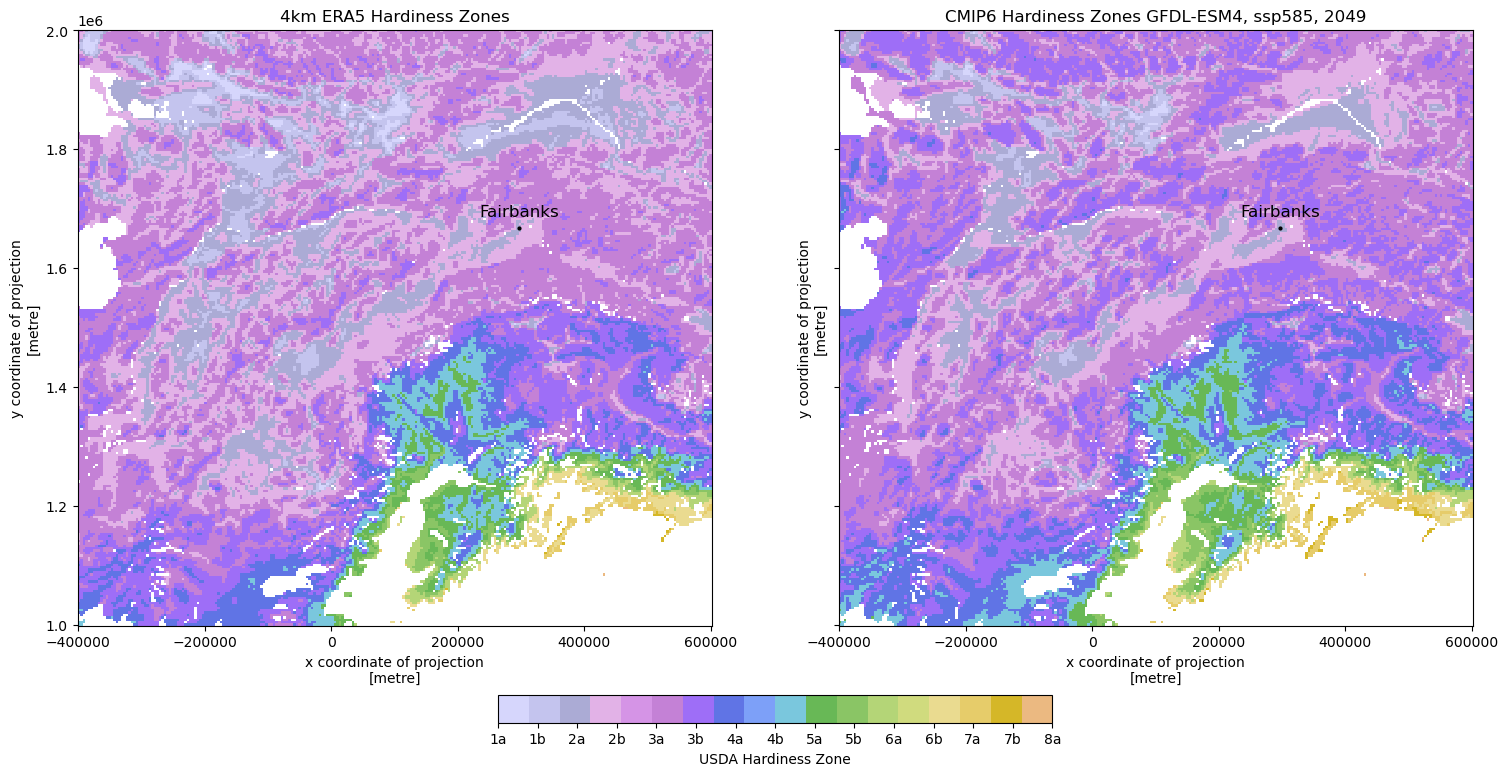

In [112]:
# 0 'CNRM-CM6-1-HR',
# 1 'EC-Earth3-Veg',
# 2 'GFDL-ESM4',
# 3 'HadGEM3-GC31-LL',
# 4 'HadGEM3-GC31-MM',
# 5 'KACE-1-0-G',
# 6 'MIROC6',
# 7 'MPI-ESM1-2-HR',
# 8 'MRI-ESM2-0'

model = models[2]
scenario = "ssp585"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), sharey=True)

sel_di = {"x": slice(-400000, 600000), "y": slice(2e6, 1e6)}
# Plot ERA5 hardiness map
ax = axes[0]
im = (
    ref_hardiness.where(~landmask.isnull())
    .sel(sel_di)
    .plot(ax=ax, cmap=cmap, add_colorbar=False)
)
ax.plot(x, y, "o", color="black", markersize=2)  # Add a smaller red dot
ax.text(x, y + 20000, "Fairbanks", color="black", fontsize=12, ha="center")
ax.set_title("4km ERA5 Hardiness Zones")

# Plot projected hardiness map
ax = axes[1]
im = (
    proj_hardiness.sel(model=model, scenario=scenario, time=str(year))
    .drop_vars("height")
    .where(~landmask.isnull())
    .sel(sel_di)
    .plot(ax=ax, cmap=cmap, add_colorbar=False)
)
ax.plot(x, y, "o", color="black", markersize=2)  # Add a smaller red dot
ax.text(x, y + 20000, "Fairbanks", color="black", fontsize=12, ha="center")
ax.set_title(f"CMIP6 Hardiness Zones {model}, {scenario}, {year}")

# Add colorbar
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="horizontal",
    fraction=0.04,
    pad=0.1,
    ticks=positions,
    format=formatter,
)
cbar.set_label("USDA Hardiness Zone")

plt.show()